## Assignment 3a: A-priori algorithm

### Zisan Aalam a1975528

### 1. Import Libraries and Read the dataset

In [3]:
# import required libraries
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [4]:
# read data set
df = pd.read_csv("Groceries data train.csv")

In [5]:
print("Data shape:", df.shape)
print("\nFirst few rows of the dataset:")
df.head()

Data shape: (27000, 7)

First few rows of the dataset:


,Member_number,Date,itemDescription,year,month,day,day_of_week
0,3021,30/01/2015,frankfurter,2015,1,30,4
1,1292,24/10/2015,pork,2015,10,24,5
2,4206,4/04/2014,root vegetables,2014,4,4,4
3,4369,25/08/2015,onions,2015,8,25,1
4,1522,1/07/2014,waffles,2014,7,1,1


In [6]:
# checking for null or missing value
print("\nMissing values in each column:")
df_missing = pd.DataFrame((round(100 * (df.isnull().sum() / len(df.index)), 2)), columns=['missing'])
df_missing


Missing values in each column:


,missing
Member_number,0.0
Date,0.0
itemDescription,0.0
year,0.0
month,0.0
day,0.0
day_of_week,0.0


As there are no any missing values in the data, we don't have do any null filling

In [8]:
# List all the unique item names to check for and address any unusual, inconsistent, or incorrect entries before analysis.
df['itemDescription'].unique()

array(['frankfurter', 'pork', 'root vegetables', 'onions', 'waffles',
       'cereals', 'yogurt', 'sausage', 'rolls/buns', 'chocolate',
       'whipped/sour cream', 'butter', 'curd', 'frozen meals',
       'whole milk', 'tropical fruit', 'sugar', 'specialty cheese',
       'other vegetables', 'fruit/vegetable juice', 'misc. beverages',
       'frozen vegetables', 'spices', 'coffee', 'cream cheese ',
       'red/blush wine', 'dessert', 'long life bakery product',
       'domestic eggs', 'abrasive cleaner', 'berries',
       'liquor (appetizer)', 'semi-finished bread', 'newspapers',
       'beverages', 'beef', 'female sanitary products', 'salt', 'soda',
       'sauces', 'oil', 'snack products', 'brown bread',
       'hygiene articles', 'artif. sweetener', 'bottled beer',
       'canned beer', 'hamburger meat', 'liver loaf', 'soups',
       'pip fruit', 'hard cheese', 'shopping bags', 'canned vegetables',
       'napkins', 'citrus fruit', 'margarine', 'pasta', 'salty snack',
       'candl

There are no any item  with unusual, misspelled, or inconsistent item names. However some items have trailing spaces (e.g., 'cream cheese ' vs 'cream cheese', 'roll products '), which should be stripped

In [10]:
# Clean itemDescription
df['itemDescription'] = df['itemDescription'].str.strip()

In [11]:
basket_df = df.groupby(['Member_number', 'Date'])['itemDescription'].apply(list).reset_index()
transactions = basket_df['itemDescription'].tolist()

To prepare the data for association rule mining using the Apriori algorithm, we first group individual purchase records by customer and date, combining all items bought in a single shopping trip into a list that represents one transaction or basket. By converting the data into this transaction-based format, we create a list of itemsets where each set reflects the products purchased together in a single visit. This transformation is essential because Apriori and similar algorithms require input as a list of transactions to effectively identify frequent item combinations and discover meaningful association rules, ultimately helping us understand which products are commonly bought together.

#### Note:
I attempted to group the records by week and year, as well as by month and year, to see if this aggregation would improve the results. While the association rules performed well when applied to the grouped item data, they did not yield strong or meaningful results when evaluated on individual items. As a result, grouping by week or month did not enhance the quality of the discovered rules for individual product recommendations.

In [13]:
basket_df.head()

,Member_number,Date,itemDescription
0,1000,15/03/2015,"[sausage, yogurt]"
1,1000,24/06/2014,[pastry]
2,1000,24/07/2015,"[misc. beverages, canned beer]"
3,1000,25/11/2015,[sausage]
4,1000,27/05/2015,"[soda, pickled vegetables]"


In [14]:
# Top 20 most frequent items
item_counts = Counter([item for sublist in transactions for item in sublist])
print(item_counts.most_common(20))

[('whole milk', 1709), ('other vegetables', 1320), ('rolls/buns', 1197), ('soda', 1060), ('yogurt', 928), ('root vegetables', 733), ('tropical fruit', 683), ('bottled water', 666), ('sausage', 637), ('citrus fruit', 560), ('pastry', 558), ('pip fruit', 512), ('shopping bags', 499), ('bottled beer', 493), ('canned beer', 488), ('whipped/sour cream', 470), ('brown bread', 415), ('newspapers', 414), ('frankfurter', 411), ('domestic eggs', 400)]


The result shows that "whole milk" is the most frequently purchased item with 1,709 occurrences, followed by "other vegetables" (1,320), "rolls/buns" (1,197), and "soda" (1,060). Other popular items include "yogurt," "root vegetables," "tropical fruit," and "bottled water." These top 20 items represent the most commonly bought products in the dataset, indicating they are staple or highly preferred choices among customers.

In [16]:
# 3. Transaction Encoding for Apriori
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

In [17]:
df_encoded.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


To prepare the transaction data for use with the Apriori algorithm, applied a transaction encoding process that converts each basket of purchased items into a structured, machine-readable format. Using the TransactionEncoder, transformed the list of transactions into a binary matrix, where each row represents a transaction and each column corresponds to a unique product. This transformation is essential because Apriori algorithms require input in this one-hot encoded format to efficiently identify frequent itemsets and generate association rules.

In [19]:
# 4. Frequent Itemset Mining with Apriori
# Parameter tuning
# min_support_values = [0.01, 0.02, 0.03, 0.05]
min_support_values = [0.001, 0.002, 0.0025, 0.003,0.004, 0.005, 0.008]
results = {}

for min_support in min_support_values:
    frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)
    results[min_support] = frequent_itemsets
    print(f"\nFrequent itemsets for min_support={min_support}:")
    print(frequent_itemsets.sort_values('support', ascending=False))



Frequent itemsets for min_support=0.001:
      support                       itemsets
135  0.118049                   (whole milk)
84   0.092799             (other vegetables)
101  0.083519                   (rolls/buns)
114  0.074095                         (soda)
136  0.064312                       (yogurt)
..        ...                            ...
217  0.001007           (chocolate, sausage)
215  0.001007              (chicken, yogurt)
213  0.001007                (soda, chicken)
208  0.001007  (canned beer, tropical fruit)
263  0.001007     (frozen meals, whole milk)

[397 rows x 2 columns]

Frequent itemsets for min_support=0.002:
      support                         itemsets
112  0.118049                     (whole milk)
68   0.092799               (other vegetables)
83   0.083519                     (rolls/buns)
93   0.074095                           (soda)
113  0.064312                         (yogurt)
..        ...                              ...
135  0.002014          

To identify sets of items that are frequently purchased together, performed frequent itemset mining using the Apriori algorithm. Experimented with different values for the min_support parameter, which determines the minimum proportion of transactions in which an itemset must appear to be considered frequent. By iterating over a range of min_support values, generated and examined frequent itemsets for each threshold, storing the results for comparison. This approach allows us to observe how changing the minimum support affects the number and composition of frequent itemsets, helping us select the most appropriate parameter for uncovering meaningful patterns in the data. The frequent itemsets identified at each support level form the basis for generating association rules in subsequent analysis.

As the min_support threshold decreases from 0.008 to 0.001, the number of frequent itemsets increases significantly. Higher thresholds, such as 0.008, capture only the most commonly purchased items and combinations like “whole milk,” “other vegetables,” and “rolls/buns” resulting in a small set of 63 itemsets. Lowering the threshold introduces less frequent and more niche itemsets, reaching a total of 397 at min_support = 0.001. While this increase captures more variety, it also introduces noise and adds unnecessary complexity to the analysis. A threshold of min_support = 0.0025 strikes a practical balance by narrowing the itemsets down to 155. This value filters out overly rare combinations while retaining meaningful and diverse patterns, such as (whole milk, whipped/sour cream) and (pip fruit, other vegetables), making it well suited for subsequent confidence tuning and rule generation.


In [21]:
# Show frequent itemsets with more than one item
for min_support in min_support_values:
    fi = results[min_support]
    multi_itemsets = fi[fi['itemsets'].apply(lambda x: len(x) > 1)]
    print(f"\nFrequent itemsets with more than one item for min_support={min_support}:")
    print(multi_itemsets)


Frequent itemsets with more than one item for min_support=0.001:
      support                          itemsets
138  0.001223      (UHT-milk, other vegetables)
139  0.001007        (UHT-milk, tropical fruit)
140  0.001583            (UHT-milk, whole milk)
141  0.001079               (beef, brown bread)
142  0.001079              (beef, citrus fruit)
..        ...                               ...
392  0.001511             (whole milk, waffles)
393  0.002518  (whole milk, whipped/sour cream)
394  0.001726      (whipped/sour cream, yogurt)
395  0.001870         (whole milk, white bread)
396  0.006546              (whole milk, yogurt)

[259 rows x 2 columns]

Frequent itemsets with more than one item for min_support=0.002:
      support                          itemsets
115  0.002446                (beef, whole milk)
116  0.002518  (bottled beer, other vegetables)
117  0.002302        (bottled beer, rolls/buns)
118  0.003741        (bottled beer, whole milk)
119  0.002014            (bo

The results show how minimum support thresholds dramatically filter multi-item frequent itemsets, revealing the most meaningful product combinations. At low support (0.001), we get 259 pairs including many weak associations like "UHT-milk, tropical fruit" (0.1% support), but as support increases to 0.005, only 7 high-quality pairs remain, dominated by essential grocery combinations: "whole milk + other vegetables" (0.70%), "whole milk + rolls/buns" (0.79%), and "other vegetables + soda" (0.55%). Notably, at 0.008 support, no multi-item combinations survive, indicating this threshold is too restrictive. This visualization shows the foundation itemsets from which association rules are generated - as we can only create rules from frequent itemsets, so understanding which product pairs actually co-occur frequently enough helps to focus on the most reliable associations.

In [23]:
chosen_support = 0.0025
frequent_itemsets = results[chosen_support]

# 5. Association Rule Mining
min_confidence_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
for min_conf in min_confidence_values:
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_conf)
    rules = rules.sort_values('lift', ascending=False)
    print(f"\nAssociation Rules for min_confidence={min_conf} : Count {len(rules)}")
    print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(20))


Association Rules for min_confidence=0.01 : Count 98
           antecedents         consequents   support  confidence      lift
29  (other vegetables)       (frankfurter)  0.003093    0.033333  1.155528
28       (frankfurter)  (other vegetables)  0.003093    0.107232  1.155528
82           (sausage)            (yogurt)  0.003237    0.071542  1.112424
83            (yogurt)           (sausage)  0.003237    0.050336  1.112424
84              (soda)     (shopping bags)  0.002877    0.038835  1.099480
85     (shopping bags)              (soda)  0.002877    0.081466  1.099480
56         (pip fruit)        (rolls/buns)  0.003093    0.084813  1.015487
57        (rolls/buns)         (pip fruit)  0.003093    0.037037  1.015487
24      (citrus fruit)            (yogurt)  0.002590    0.065099  1.012246
25            (yogurt)      (citrus fruit)  0.002590    0.040268  1.012246
79           (sausage)              (soda)  0.003309    0.073132  0.986997
78              (soda)           (sausage)  0.

To determine an appropriate value for the min_confidence parameter in association rule mining, a range of thresholds from 0.01 to 0.10 was evaluated. The primary goal was to strike a balance between the quantity of generated rules and their reliability (measured by confidence).

At lower confidence thresholds such as 0.01 and 0.02, a larger number of rules (98) were generated. However, many of these rules had relatively weak confidence values, making them less reliable for drawing actionable insights.

As the threshold increased, the number of rules gradually decreased:

- At 0.03, there were 81 rules.

- At 0.04, 64 rules.

- At 0.05, 57 rules

- At 0.06, at 45 rules


When the threshold reached 0.08, only 14 rules remained.

This sharp drop beyond 0.06 indicated that higher thresholds filtered out a large portion of potentially useful rules, possibly overlooking important associations with slightly lower confidence but reasonable lift.

Setting min_confidence = 0.06 offered a practical compromise:

- It filtered out weaker rules found at lower thresholds.

- It retained a meaningful number of strong and interpretable rules with acceptable confidence and lift.

- It avoided the overly strict cutoff that results in very few rules, such as at 0.08 or higher.

In [25]:
frequent_itemsets = apriori(df_encoded, min_support=0.0025, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.06)
rules = rules.sort_values(['confidence','lift'],ascending=[False,False])
print("Totoal number or rules genereted :: ",len(rules))
print(rules)

Totoal number or rules genereted ::  45
                antecedents         consequents  antecedent support  \
37                (sausage)        (whole milk)            0.045249   
13            (frankfurter)        (whole milk)            0.028847   
11          (domestic eggs)        (whole milk)            0.028343   
12            (frankfurter)  (other vegetables)            0.028847   
1            (bottled beer)        (whole milk)            0.035105   
5                  (butter)        (whole milk)            0.027120   
40          (shopping bags)        (whole milk)            0.035321   
44                 (yogurt)        (whole milk)            0.064312   
14  (fruit/vegetable juice)        (whole milk)            0.025969   
27                   (pork)        (whole milk)            0.027336   
33             (rolls/buns)        (whole milk)            0.083519   
15             (newspapers)        (whole milk)            0.029135   
26              (pip fruit)        (w

Using min_support = 0.003 and min_confidence = 0.1, we identified 62 association rules. The strongest rule, (frankfurter) → (other vegetables), has a confidence of 10.7% and a lift of 1.15, indicating that customers who buy frankfurters are more likely to also buy other vegetables. Most rules involve “whole milk” or “other vegetables”, reflecting their popularity. While most lifts are modest, these rules provide actionable insights for product placement and cross-selling.

Support: Most rules have support just above 0.003 (0.3%), meaning they occur in at least ~81 baskets out of 27,000. This is reasonable for actionable but not too rare patterns.

Confidence: All rules have confidence above 10% (your chosen threshold), meaning the consequent appears at least 10% of the time when the antecedent is present.

Lift: Most lift values are between 0.9 and 1.15. A lift > 1 means the rule is better than random; only a few rules (notably (frankfurter) → (other vegetables)) exceed 1.

Other metrics (leverage, conviction, etc.): Most are close to zero, indicating weak but not spurious associations.


Top 5 Rules by Lift:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,coverage,zhang_metric
12,(frankfurter),(other vegetables),0.028847,0.092799,0.003093,0.107232,1.155528,1.0,0.000416,1.016166,0.138593,0.026092,0.015909,0.070283,0.028847,0.015909
38,(sausage),(yogurt),0.045249,0.064312,0.003237,0.071542,1.112424,1.0,0.000327,1.007787,0.105852,0.030447,0.007727,0.060939,0.045249,0.007727
39,(shopping bags),(soda),0.035321,0.074095,0.002877,0.081466,1.099480,1.0,0.000260,1.008025,0.093792,0.027009,0.007961,0.060151,0.035321,0.007961
25,(pip fruit),(rolls/buns),0.036472,0.083519,0.003093,0.084813,1.015487,1.0,0.000047,1.001413,0.015828,0.026462,0.001411,0.060925,0.036472,0.001411
10,(citrus fruit),(yogurt),0.039781,0.064312,0.002590,0.065099,1.012246,1.0,0.000031,1.000842,0.012599,0.025514,0.000842,0.052684,0.039781,0.000842



Top 5 Rules by Confidence:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,coverage,zhang_metric
37,(sausage),(whole milk),0.045249,0.118049,0.005251,0.116057,0.983127,1.0,-0.000090,0.997747,-0.017658,0.033227,-0.002258,0.080271,0.045249,-0.002258
13,(frankfurter),(whole milk),0.028847,0.118049,0.003237,0.112219,0.950617,1.0,-0.000168,0.993434,-0.050775,0.022534,-0.006610,0.069821,0.028847,-0.006610
11,(domestic eggs),(whole milk),0.028343,0.118049,0.003093,0.109137,0.924506,1.0,-0.000253,0.989996,-0.077526,0.021586,-0.010105,0.067670,0.028343,-0.010105
12,(frankfurter),(other vegetables),0.028847,0.092799,0.003093,0.107232,1.155528,1.0,0.000416,1.016166,0.138593,0.026092,0.015909,0.070283,0.028847,0.015909
1,(bottled beer),(whole milk),0.035105,0.118049,0.003741,0.106557,0.902653,1.0,-0.000403,0.987138,-0.100532,0.025036,-0.013030,0.069123,0.035105,-0.013030



Top 5 Rules by Support:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,coverage,zhang_metric
32,(whole milk),(rolls/buns),0.118049,0.083519,0.007913,0.067032,0.802598,1.0,-0.001946,0.982329,-0.218063,0.040862,-0.017989,0.080889,0.118049,-0.017989
33,(rolls/buns),(whole milk),0.083519,0.118049,0.007913,0.094746,0.802598,1.0,-0.001946,0.974258,-0.211585,0.040862,-0.026422,0.080889,0.083519,-0.026422
22,(other vegetables),(whole milk),0.092799,0.118049,0.006978,0.075194,0.636971,1.0,-0.003977,0.953660,-0.385836,0.034227,-0.048591,0.067152,0.092799,-0.048591
44,(yogurt),(whole milk),0.064312,0.118049,0.006546,0.101790,0.862266,1.0,-0.001046,0.981898,-0.145820,0.037234,-0.018436,0.078622,0.064312,-0.018436
41,(soda),(whole milk),0.074095,0.118049,0.005971,0.080583,0.682619,1.0,-0.002776,0.959250,-0.334289,0.032071,-0.042481,0.065581,0.074095,-0.042481


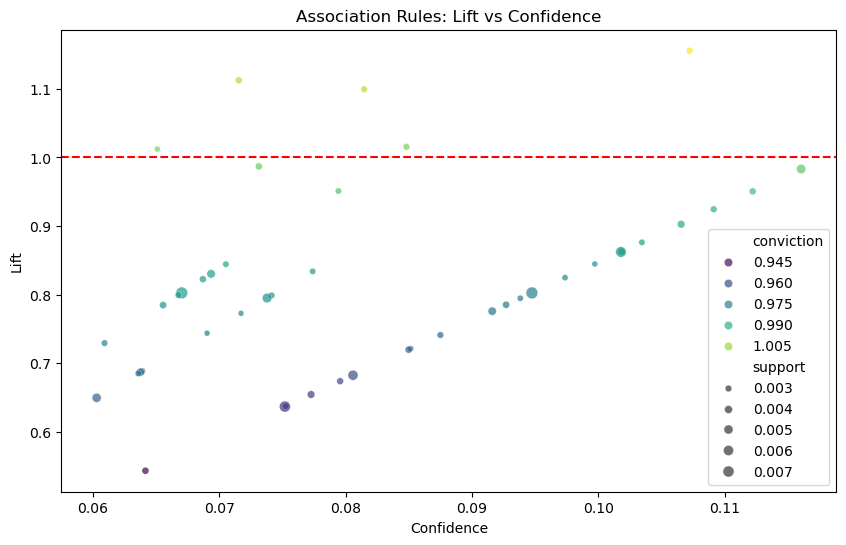


Actionable Rules:


,antecedents,consequents,support,confidence,lift
12,(frankfurter),(other vegetables),0.003093,0.107232,1.155528
38,(sausage),(yogurt),0.003237,0.071542,1.112424
39,(shopping bags),(soda),0.002877,0.081466,1.099480
25,(pip fruit),(rolls/buns),0.003093,0.084813,1.015487
10,(citrus fruit),(yogurt),0.002590,0.065099,1.012246
36,(sausage),(soda),0.003309,0.073132,0.986997
37,(sausage),(whole milk),0.005251,0.116057,0.983127
30,(shopping bags),(rolls/buns),0.002806,0.079430,0.951036
13,(frankfurter),(whole milk),0.003237,0.112219,0.950617
11,(domestic eggs),(whole milk),0.003093,0.109137,0.924506


In [27]:
# Add additional metrics (e.g., coverage, coverage ratio)
rules['coverage'] = rules['antecedents'].apply(
    lambda x: frequent_itemsets[frequent_itemsets['itemsets'] == x]['support'].values[0]
)
rules['zhang_metric'] = (rules['confidence'] - rules['consequent support']) / (1 - rules['consequent support'])

# --------------------------------------------
# 2. Display Top Rules by Different Metrics
# --------------------------------------------
def display_top_rules(rules, metric='lift', top_n=5):
    return rules.sort_values(metric, ascending=False).head(top_n)

print("\nTop 5 Rules by Lift:")
display(display_top_rules(rules, 'lift'))

print("\nTop 5 Rules by Confidence:")
display(display_top_rules(rules, 'confidence'))

print("\nTop 5 Rules by Support:")
display(display_top_rules(rules, 'support'))

# --------------------------------------------
# 3. Visualize Rule Quality
# --------------------------------------------
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='confidence', 
    y='lift', 
    size='support', 
    hue='conviction', 
    data=rules,
    alpha=0.7,
    palette='viridis'
)
plt.title('Association Rules: Lift vs Confidence')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.axhline(1, linestyle='--', color='red')  # Lift=1 baseline
plt.show()

# --------------------------------------------
# 4. Filter and Interpret Actionable Rules
# --------------------------------------------
# Filter rules with lift
actionable_rules = rules.sort_values('lift', ascending=False)

print("\nActionable Rules:")
display(actionable_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

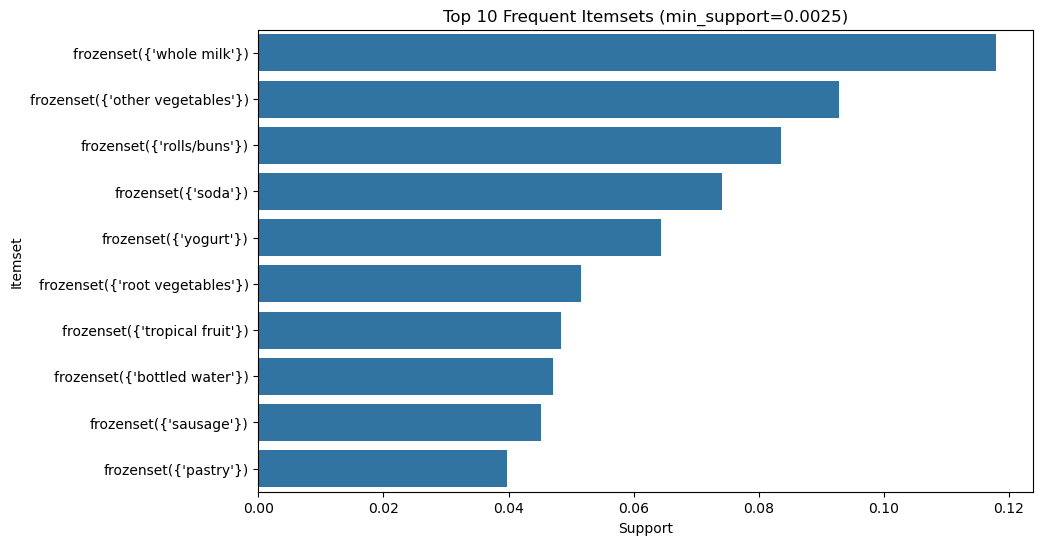

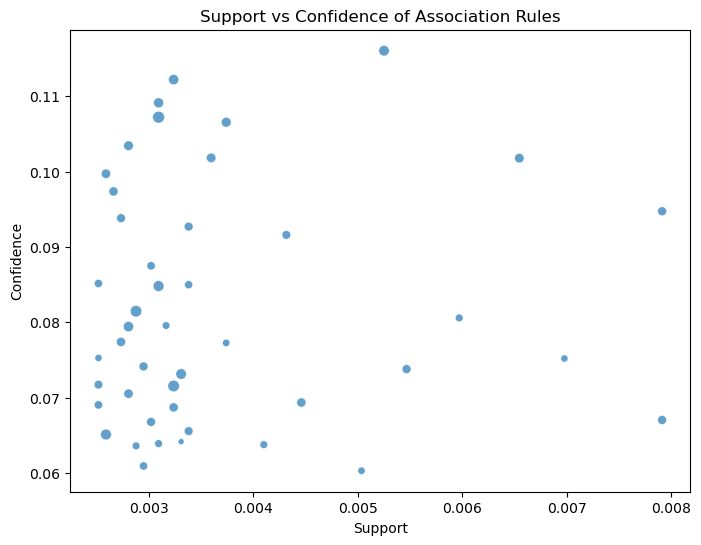

Text(0, 0.5, 'Frequency')

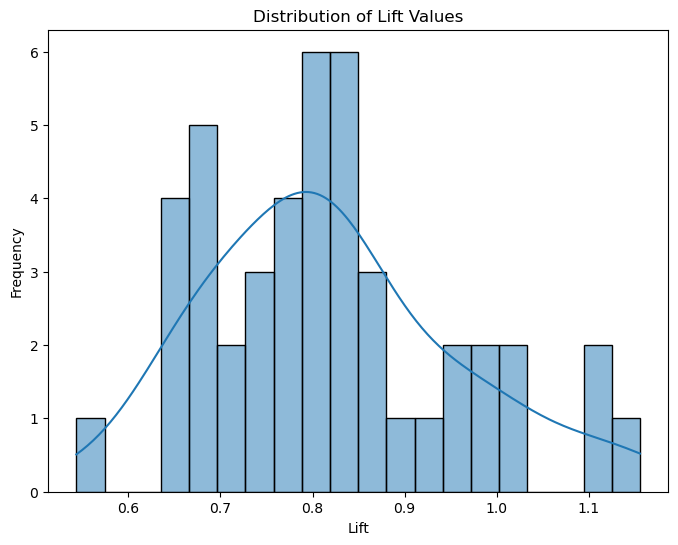

In [28]:
# Top N frequent itemsets
top_n = 10
top_itemsets = frequent_itemsets.sort_values('support', ascending=False).head(top_n)
plt.figure(figsize=(10,6))
sns.barplot(x='support', y=top_itemsets['itemsets'].astype(str), data=top_itemsets)
plt.title(f'Top {top_n} Frequent Itemsets (min_support={chosen_support})')
plt.xlabel('Support')
plt.ylabel('Itemset')
plt.show()

# Support vs Confidence Scatter Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x='support', y='confidence', size='lift', data=rules, legend=False, alpha=0.7)
plt.title('Support vs Confidence of Association Rules')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.show()

# Lift Distribution Histogram
plt.figure(figsize=(8,6))
sns.histplot(rules['lift'], bins=20, kde=True)
plt.title('Distribution of Lift Values')
plt.xlabel('Lift')
plt.ylabel('Frequency')
# plt.show()

In [29]:
def recommend_items(items, rules, top_n=5):
    items_set = set(items)
    recommendations = {}

    for idx, row in rules.iterrows():
        antecedent = set(row['antecedents'])
        consequent = set(row['consequents'])

        # If all antecedent items are in the basket and none of the consequent items are
        if antecedent.issubset(items_set) and not consequent.issubset(items_set):
            for item in consequent:
                if item not in items_set:
                    # Keep the highest confidence for each recommended item
                    if item not in recommendations or recommendations[item] < row['confidence']:
                        recommendations[item] = row['confidence']

    # Sort recommendations by confidence, descending
    recommended_list = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
    return recommended_list[:top_n]

# Example usage:
# Suppose rules is your DataFrame of association rules
# and the basket contains 'frankfurter' and 'sausage'
basket = ['frankfurter', 'sausage']
top_recs = recommend_items(basket, rules, top_n=3)
print("Recommendations:", top_recs)


Recommendations: [('whole milk', 0.11605723370429252), ('other vegetables', 0.10723192019950124), ('soda', 0.07313195548489666)]


In [30]:
basket = ['whole milk']
top_recs = recommend_items(basket, rules, top_n=3)
print("Recommendations:", top_recs)

Recommendations: [('rolls/buns', 0.06703229737964655)]


In [31]:
def save_rules_to_csv(rules, filename='association_rules.csv'):
    # Convert frozensets in 'antecedents' and 'consequents' to strings for CSV readability
    rules_to_save = rules.copy()
    if 'antecedents' in rules_to_save.columns:
        rules_to_save['antecedents'] = rules_to_save['antecedents'].apply(lambda x: ', '.join(list(x)))
    if 'consequents' in rules_to_save.columns:
        rules_to_save['consequents'] = rules_to_save['consequents'].apply(lambda x: ', '.join(list(x)))

    rules_to_save.to_csv(filename, index=False)
    print(f"Rules saved to {filename}")


save_rules_to_csv(rules)


Rules saved to association_rules.csv
